<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Random_Forest_on_correlation_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [751]:
! git clone https://github.com/anirbanghoshsbi/pandas-technical-indicators.git

Cloning into 'pandas-technical-indicators'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 202 (delta 105), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (202/202), 58.64 KiB | 9.77 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [752]:
!pwd

/content/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators


In [753]:
%cd pandas-technical-indicators

/content/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators


In [754]:

# Import libraries
import os
import sys
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import technical_indicators as ta
import random_forest as rf
import confusionMatrix as cm
import easy_line_ploting as linplt

In [755]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd

In [756]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import datetime

In [757]:
#@title Default title text
def moving_average(df, n):
    """Calculate the moving average for the given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


def exponential_moving_average(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    return df


def momentum(df, n):
    """
    
    :param df: pandas.DataFrame 
    :param n: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df


def rate_of_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(n - 1)
    N = df['Close'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROC_' + str(n))
    df = df.join(ROC)
    return df

def bollinger_bands(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
    MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
    b1 = 4 * MSD / MA
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    df = df.join(B1)
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    df = df.join(B2)
    return df
def stochastic_oscillator_k(df):
    """Calculate stochastic oscillator %K for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    df = df.join(SOk)
    return df


def stochastic_oscillator_d(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df
def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df
def vortex_indicator(df, n,name='data_0'):
    """Calculate the Vortex Indicator for given data.
    
    Vortex Indicator described here:
        http://www.vortexindicator.com/VFX_VORTEX.PDF
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR = [0]
    df.reset_index(inplace=True)
    while i < df.index[-1]:
        Range = max(df.iloc[i + 1, 2], df.iloc[i, 4]) - min(df.iloc[i + 1, 3], df.iloc[i, 4])
        TR.append(Range)
        i = i + 1
    i = 0
    VM = [0]
    while i < df.index[-1]:
        Range = abs(df.iloc[i + 1, 2] - df.iloc[i, 3]) - abs(df.iloc[i + 1, 3] - df.iloc[i, 2])
        VM.append(Range)
        i = i + 1
    VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_'+name+ str(n))
    df = df.join(VI)
    df=df.set_index("date") 	
    return df
def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    df.reset_index(inplace=True)	
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    df= df.set_index('Date')	
    return df                

In [758]:
data_p = pd.read_csv('/content/MCX_COPPER1!, 1D.csv')

In [759]:

data_p['date']=data_p.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))


In [760]:
data_p.shape

(1606, 20)

In [761]:

del data_p['time']
del data_p['Volume']
del data_p['Volume MA']

In [762]:
data=data_p[:1000]
real=data_p[1000:]

In [763]:
data.tail(2)

,open,high,low,close,"NIFTY, NSE: Open","NIFTY, NSE: High","NIFTY, NSE: Low","NIFTY, NSE: Close","INDIAVIX, NSE: Open","INDIAVIX, NSE: High","INDIAVIX, NSE: Low","INDIAVIX, NSE: Close","GLD, CBOE BZX: Open","GLD, CBOE BZX: High","GLD, CBOE BZX: Low","GLD, CBOE BZX: Close",date
998,452.20,452.7,443.8,445.15,11382.50,11383.45,11313.75,11343.25,15.2775,15.5225,13.7625,15.150,122.33,122.545,122.1200,122.41,14-03-2019
999,446.45,449.0,443.5,445.55,11376.85,11487.00,11370.80,11426.85,15.1500,16.3925,11.8450,15.865,123.06,123.400,122.9132,122.97,15-03-2019


In [764]:
real.tail(2)

,open,high,low,close,"NIFTY, NSE: Open","NIFTY, NSE: High","NIFTY, NSE: Low","NIFTY, NSE: Close","INDIAVIX, NSE: Open","INDIAVIX, NSE: High","INDIAVIX, NSE: Low","INDIAVIX, NSE: Close","GLD, CBOE BZX: Open","GLD, CBOE BZX: High","GLD, CBOE BZX: Low","GLD, CBOE BZX: Close",date
1604,729.0,737.25,725.20,734.2,16274.8,16359.25,16202.25,16280.10,12.605,13.0675,9.9825,12.7050,161.39,162.11,160.68,161.77,10-08-2021
1605,732.3,736.00,728.75,735.3,16327.3,16338.75,16162.55,16282.25,12.705,13.3275,10.4725,12.7125,163.15,164.17,162.68,164.00,11-08-2021


In [765]:
data= data.set_index('date')
#real.rename(columns={'date':'Date'},inplace=True)
real=real.set_index('date')

In [766]:
data_0=data.iloc[:,0:4]

data_1=data.iloc[:,4:8]
data_2=data.iloc[:,8:12]
data_3=data.iloc[:,12:16]



    

In [767]:
data_1

,"NIFTY, NSE: Open","NIFTY, NSE: High","NIFTY, NSE: Low","NIFTY, NSE: Close"
date,,,,
02-03-2015,8953.8496,8972.3496,8885.4502,8956.7500
03-03-2015,8962.8496,9008.4004,8925.5498,8996.2500
04-03-2015,9109.1504,9119.2002,8893.9502,8922.6504
05-03-2015,8929.4004,8957.5498,8849.3496,8937.7500
09-03-2015,8891.1504,8891.2998,8740.4502,8756.7500
...,...,...,...,...
11-03-2019,11068.7500,11180.9000,11059.8500,11168.0500
12-03-2019,11231.3500,11320.4000,11227.0000,11301.2000
13-03-2019,11326.2000,11352.3000,11276.6000,11341.7000


# Input

In [768]:
# INPUT .........

#  ********************************* #

t=2
days_out=24


#  ********************************* #

In [769]:
def get_indicators(data_0,data_1,data_2,data_3,days_out,t=1,type='Cu'):

    data_0 = vortex_indicator(data_0.iloc[:,0:4] , days_out,name='data_0_')
    data_1 = vortex_indicator(data_1.iloc[:,0:4] , days_out,name='data_1_')
    data_2 = vortex_indicator(data_2.iloc[:,0:4] , days_out,name='data_2_')
    data_3 = vortex_indicator(data_3.iloc[:,0:4] , days_out,name='data_3_')
    data_f=pd.concat([data_0,data_1,data_2,data_3],axis=1)
    
    return data_f

In [770]:
train_0=int(len(data_0)*.75)
df_train_0= data_0[:train_0]
df_test_0= data_0[train_0+50:]
train_1=int(len(data_1)*.75)
df_train_1= data_1[:train_1]
df_test_1= data_1[train_1+50:]
train_2=int(len(data_2)*.75)
df_train_2= data_2[:train_2]
df_test_2= data_2[train_2+50:]
train_3=int(len(data_3)*.75)
df_train_3= data_3[:train_3]
df_test_3= data_3[train_3+50:]

In [771]:
df_train = get_indicators(df_train_0,df_train_1,df_train_2,df_train_3,days_out,1)
df_test= get_indicators(df_test_0,df_test_1,df_test_2,df_test_3,days_out,1)

In [772]:
df_train.shape , df_test.shape

((750, 20), (200, 20))

In [773]:
df_train.tail(5)

,open,high,low,close,Vortex_data_0_24,"NIFTY, NSE: Open","NIFTY, NSE: High","NIFTY, NSE: Low","NIFTY, NSE: Close",Vortex_data_1_24,"INDIAVIX, NSE: Open","INDIAVIX, NSE: High","INDIAVIX, NSE: Low","INDIAVIX, NSE: Close",Vortex_data_2_24,"GLD, CBOE BZX: Open","GLD, CBOE BZX: High","GLD, CBOE BZX: Low","GLD, CBOE BZX: Close",Vortex_data_3_24
date,,,,,,,,,,,,,,,,,,,,
07-03-2018,454.30,455.00,449.80,452.05,-0.015482,10232.95,10243.35,10141.55,10154.20,-0.482785,16.245001,16.459999,13.4475,15.7000,-0.056350,126.22,126.29,125.420,125.72,NaN
08-03-2018,452.00,452.35,444.20,445.30,-0.099794,10216.25,10270.35,10146.40,10242.65,-0.435358,15.700000,15.700000,12.4850,14.5850,-0.032924,125.69,125.70,125.125,125.42,NaN
09-03-2018,444.70,454.00,442.45,452.30,-0.096790,10271.30,10296.70,10211.90,10226.85,-0.416034,14.585000,14.762500,12.9050,14.5250,-0.039860,124.94,125.69,124.780,125.54,NaN
12-03-2018,452.65,453.35,448.50,450.25,-0.101007,10301.60,10433.65,10295.45,10421.40,-0.269229,14.525000,14.662500,12.0100,14.4925,-0.004250,125.04,125.57,124.840,125.54,NaN
13-03-2018,449.85,451.80,447.65,450.95,-0.133191,10389.50,10478.60,10377.85,10426.85,-0.135042,14.492500,14.620000,12.3875,14.4625,-0.087666,125.67,125.99,125.050,125.78,NaN


In [774]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['NIFTY, NSE: Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()

In [775]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['NIFTY, NSE: Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_test = df_test.dropna()

In [776]:
X_train = df_train.drop(['Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [777]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=80,min_samples_leaf=2,max_features='auto', min_samples_split=2, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [778]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction RForest (%):  97.82608695652173


In [779]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns

In [780]:
#feats=['Vortex_data_1_24','Vortex_data_2_24','INDIAVIX, NSE: High','INDIAVIX, NSE: Close']

In [781]:
real.tail(2)

,open,high,low,close,"NIFTY, NSE: Open","NIFTY, NSE: High","NIFTY, NSE: Low","NIFTY, NSE: Close","INDIAVIX, NSE: Open","INDIAVIX, NSE: High","INDIAVIX, NSE: Low","INDIAVIX, NSE: Close","GLD, CBOE BZX: Open","GLD, CBOE BZX: High","GLD, CBOE BZX: Low","GLD, CBOE BZX: Close"
date,,,,,,,,,,,,,,,,
10-08-2021,729.0,737.25,725.20,734.2,16274.8,16359.25,16202.25,16280.10,12.605,13.0675,9.9825,12.7050,161.39,162.11,160.68,161.77
11-08-2021,732.3,736.00,728.75,735.3,16327.3,16338.75,16162.55,16282.25,12.705,13.3275,10.4725,12.7125,163.15,164.17,162.68,164.00


In [782]:
real_0=real.iloc[:,0:4]
real_1=real.iloc[:,4:8]
real_2=real.iloc[:,8:12]
real_3=real.iloc[:,12:16]

In [783]:
df_real = get_indicators(real_0,real_1,real_2,real_3,days_out,1)

In [784]:
price_data_new = df_real.copy()

In [785]:
# Group by the `Symbol` column, then grab the `Close` column.
close_groups = df_real['NIFTY, NSE: Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
price_data_new['Signal_Flag'] = close_groups
price_data_new = price_data_new.dropna()

In [786]:
ppp =price_data_new.reset_index()

In [787]:
ppp.tail(2)

,date,open,high,low,close,Vortex_data_0_24,"NIFTY, NSE: Open","NIFTY, NSE: High","NIFTY, NSE: Low","NIFTY, NSE: Close",Vortex_data_1_24,"INDIAVIX, NSE: Open","INDIAVIX, NSE: High","INDIAVIX, NSE: Low","INDIAVIX, NSE: Close",Vortex_data_2_24,"GLD, CBOE BZX: Open","GLD, CBOE BZX: High","GLD, CBOE BZX: Low","GLD, CBOE BZX: Close",Vortex_data_3_24,Signal_Flag
126,12-11-2020,534.35,538.95,532.30,535.90,0.081566,12702.15,12741.15,12624.85,12690.80,0.281952,22.032499,22.032499,19.787500,20.620001,0.045012,176.04,176.765,175.84,175.96,0.117746,1.0
127,13-11-2020,536.00,541.80,534.35,540.85,0.087466,12659.70,12735.95,12607.70,12719.95,0.243640,20.620001,29.525000,19.557501,19.702499,0.094168,177.65,177.800,176.84,177.16,0.152866,1.0


In [788]:

pred = pd.DataFrame(rand_frst_clf.predict(price_data_new[feats]))
pred = pd.concat([pred , ppp.date,ppp['NIFTY, NSE: Close']],axis=1)
pred.columns=['pred','date','Close']
pred= pred.set_index('date')

In [789]:
l=len(pred)

In [803]:
l

128

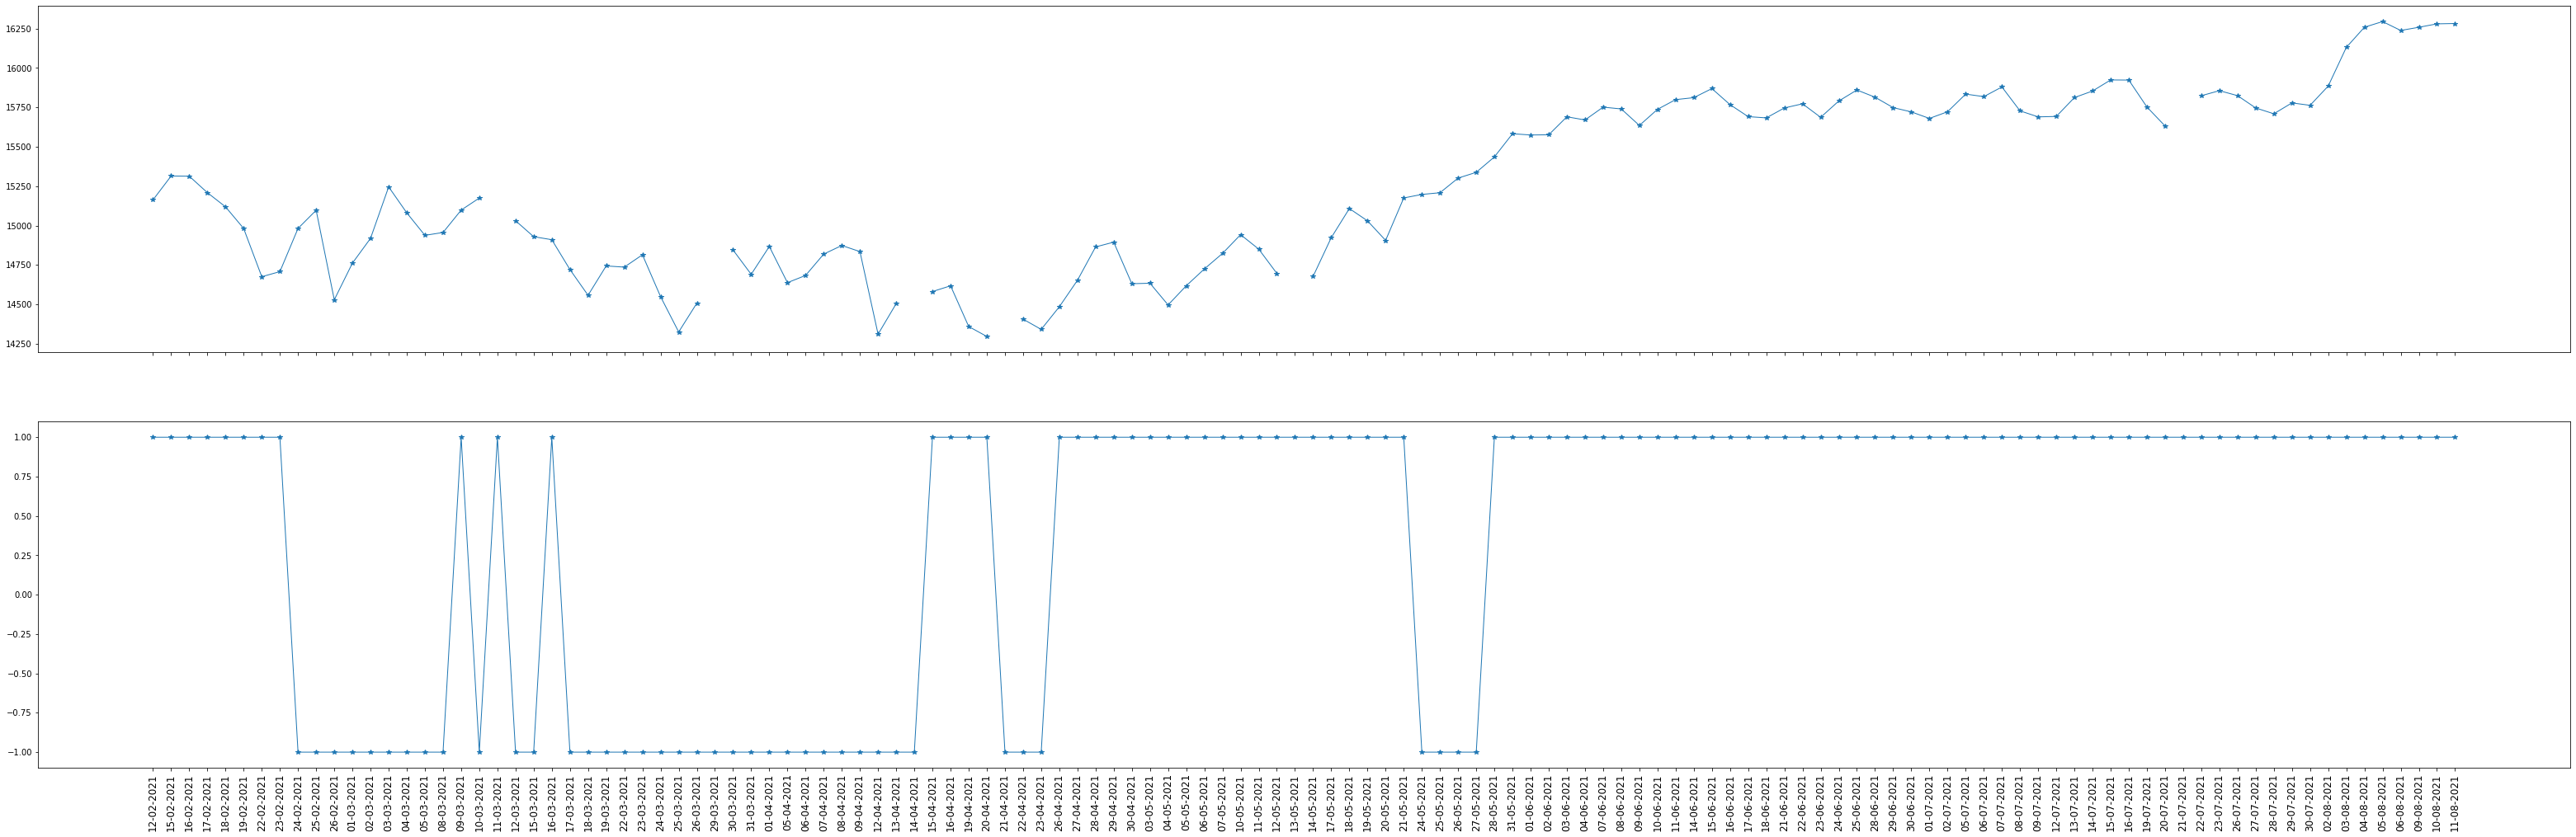

In [810]:
fig, ax = plt.subplots(2,1,figsize=(55,17),sharex=True)
ax[0].plot(df_real.index.values[-l:],df_real['NIFTY, NSE: Close'].values[-l:],'*-',linewidth=1 )
ax[1].plot(df_real.index.values[-l:],pred.pred.values[-l:],'*-',linewidth=1 )
plt.xticks(fontsize=12, rotation=90)
plt.show()

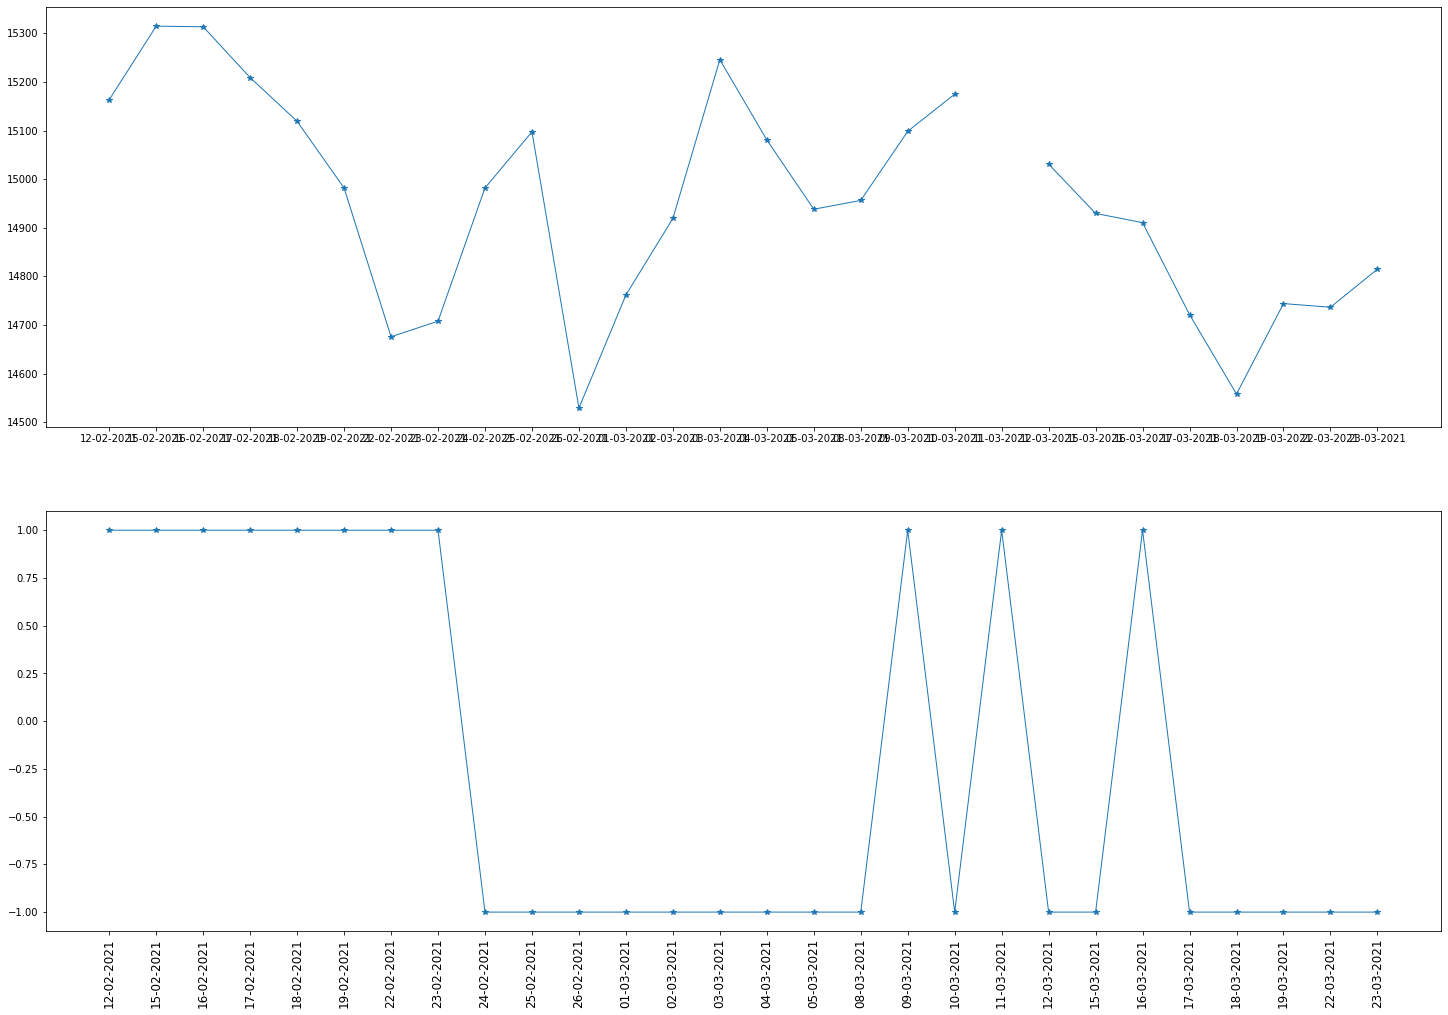

In [806]:
fig, ax = plt.subplots(2,1,figsize=(25,17))
ax[0].plot(df_real.index.values[-l:-100],df_real['NIFTY, NSE: Close'].values[-l:-100],'*-',linewidth=1 )
ax[1].plot(df_real.index.values[-l:-100],pred.pred.values[-l:-100],'*-',linewidth=1 )
plt.xticks(fontsize=12, rotation=90)
plt.show()